This project is about [**Customer Segmentation**](https://www.mktr.ai/how-to-ignite-growth-with-customer-segmentation/) that 
I aim to *cluster a customer base into meaningful groups*.

# Data Description
The data used is referenced from [UC Irvine’s Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/online+retail).

This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.



# Overview

**1. Understand the nature of data (Histograms, boxplots, etc.)**

**2. Data Exploration**

**3. Data Cleaning**

**4. Feature Engineering**

**5. Data Preprocessing and Building Models**

In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load Data

In [ ]:
# load data
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# quickly look at our data fields, datatype and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


I'd like to look at the provided **Attribute Information**.

|Field name | Description |
|--|--|
|***InvoiceNo***| Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation. |
|***StockCode*** | Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.|
|***Description***| Product (item) name. Nominal.|
|***Quantity***| The quantities of each product (item) per transaction. Numeric.|
|***InvoiceDate*** | Invice Date and time. Numeric, the day and time when each transaction was generated.|
|***UnitPrice***| Unit price. Numeric, Product price per unit in sterling.|
|***CustomerID***| Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.|
|***Country*** | Country name. Nominal, the name of the country where each customer resides.|

# Light Data Exploration

## Numeric Variables

In [ ]:
# to better understand numeric data, 
# we uses .describe() method
# which gives us understanding of the central tendencies of the data
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


I put a notice on `Quantity`, and `UnitPrice` columns. There are some negative values.

- For `Quantity`, the *min value is -80995*. I guess this is the cancelled or refunded orders.
- For `UnitPrice`, the *min value is about -11062*. I leave it for considering latter.


In [ ]:
# I check my guess that orders with negative quantities is cancelled.

## get out negative-quantity orders
neg_quantities = df.loc[df['Quantity'] <= 0]

## check: InvoiceNo of negative-quantiy orders starts with letter 'c'
if all(neg_quantities['InvoiceNo'].str.startswith(('c', 'C'))):
  print('ALL negative-quantity orders starts with letter "c".')
else:
  print('NOT ALL negative-quantity orders starts with letter "c".')

ALL negative-quantity orders starts with letter "c".


In [ ]:
# I check other guess: All cancelled orders has negative quantities.

## get out orders whose InvoiceNo starts with 'c' 
c_orders = df.loc[df['InvoiceNo'].str.startswith(('c', 'C')) == True]

# check: All cancelled orders has negative quantities.
if all(c_orders['Quantity'] < 0):
  print('ALL cancelled orders has negative quantities.') 
else:
  print('NOT ALL cancelled orders has negative quantities.') 

ALL cancelled orders has negative quantities.


In [ ]:
# I check another interesting guess: 
# An cancelled orders whose InvoiceNo starts with 'c' 
# maps with an order whose InvoiceNo is exactly the same except 'c'

if all(c_orders['InvoiceNo'].str.replace('c', '', 1).isin(df['InvoiceNo'])):
  print('An cancelled orders produces 2 records/ invoices in the database: one for purchasing, one for refunding.')
else:
  print('Cancelled orders updates their InvoiceNo by adding letter "C" at the beginning.')

An cancelled orders produces 2 records/ invoices in the database: one for purchasing, one for refunding.


So, cancelled orders has negative quantity, and vice versa. 

As we focus only on purchased orders/ customers, I will remove those cancelled orders. 



In [ ]:
# remove cancelled orders
df = df.loc[df['Quantity'] > 0]

Recall, column `UnitPrice` also contains some negatives. I take a close look into them.

In [ ]:
df.loc[df['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


Just 2 records with null `CustomerID`. It maybe due to some mistakes at the datatyping stage. By the way, I will remove all null `CustomerID`.

In [ ]:
# remove null CustomerIDs
df = df.loc[df['CustomerID'].notnull()]

In [ ]:
# check the data after doing some cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.3+ MB


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [ ]:
# quickly get numeric columns
df.describe().columns

Index(['Quantity', 'UnitPrice', 'CustomerID'], dtype='object')

In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [ ]:
# look at numeric and categorical values separately
df_num = df[['Quantity', 'UnitPrice']]
df_cat = df[['StockCode', 'Country']]

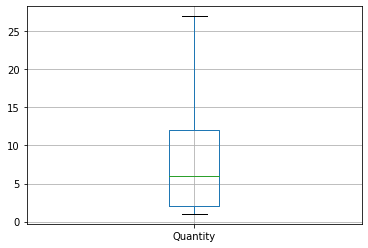

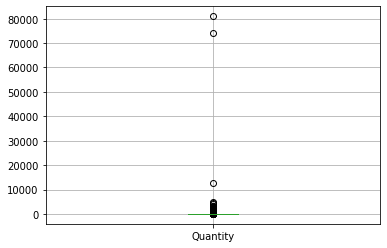

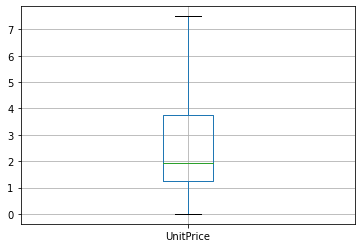

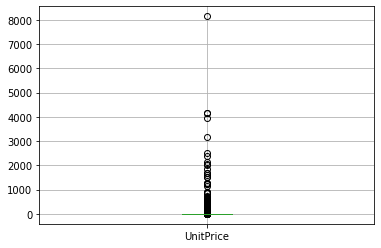

In [ ]:
# understand the distributions for all numerics
for v in df_num.columns:
  ax = df_num[v].plot.box(showfliers=False, grid=True,)
  plt.show()

  ax = df_num[v].plot.box(showfliers=True, grid=True,)
  plt.show()

           Quantity  UnitPrice
Quantity   1.000000  -0.004561
UnitPrice -0.004561   1.000000


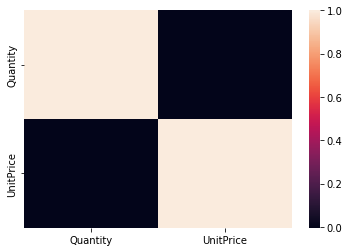

In [ ]:
print(df_num.corr())
sns.heatmap(df_num.corr())

## Understanding on Business Growth

We will look at the overall time-series trends in the sales and revenue.

I roughly outline my steps using commented cells.

In [ ]:
# Monthly Sales
## Resample to monthly sales
## Plot a line chart on timeseries vs. The total number of orders/invoices.
## Draw a trendline
## Make some conclusions

# Monthly Revenue
## Calculate Revenue = UnitPrice * Quantity
## Resample to monthly revenue
## Plot a line chart on timeseries vs. The total revenue.
## Draw a trendline
## Make some conclusions

### Monthly Sales

In [ ]:
# Resample to monthly sales
monthly_sales_df = df.set_index('InvoiceDate')['InvoiceNo'].resample('M').nunique()
monthly_sales_df

InvoiceDate
2010-12-31    1400
2011-01-31     987
2011-02-28     998
2011-03-31    1321
2011-04-30    1149
2011-05-31    1555
2011-06-30    1393
2011-07-31    1331
2011-08-31    1281
2011-09-30    1756
2011-10-31    1929
2011-11-30    2658
2011-12-31     778
Freq: M, Name: InvoiceNo, dtype: int64

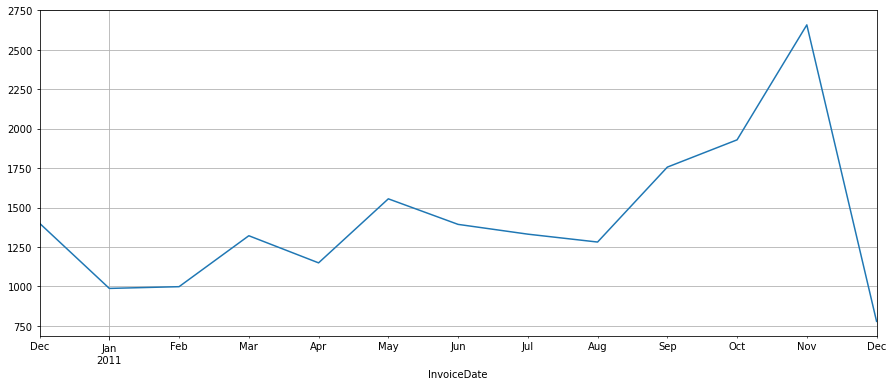

In [ ]:
# make a line plot to understand timeseries overal trends
plt.figure(figsize=(15, 6))
monthly_sales_df.plot(grid=True)

I realize a sharp drop in sales in December.

As provided, the data is just up to 09/12/2011. The uncomplete data in December leads to the drop down.

In [ ]:
# verify the uncomplete data in Dec 2011
print(f"Min date of Dec-2011: {min(df.loc[df['InvoiceDate'] >= '2011-12-01']['InvoiceDate'])}")
print(f"Max date of Dec-2011: {max(df.loc[df['InvoiceDate'] >= '2011-12-01']['InvoiceDate'])}")

Min date of Dec-2011: 2011-12-01 08:33:00
Max date of Dec-2011: 2011-12-09 12:50:00


In [ ]:
# verify the very first date in the data
# to make sure the Dec-2010 data is complete.
print(f"Min InvoiceDate: {min(df['InvoiceDate'])}")

Min InvoiceDate: 2010-12-01 08:26:00


In [ ]:
# remove data in Dec 2011 
# because any analysis with this uncomplete data is not very useful.
df = df.loc[df['InvoiceDate'] < '2011-12-01']
monthly_sales_df = monthly_sales_df.loc[monthly_sales_df.index < '2011-12-01']

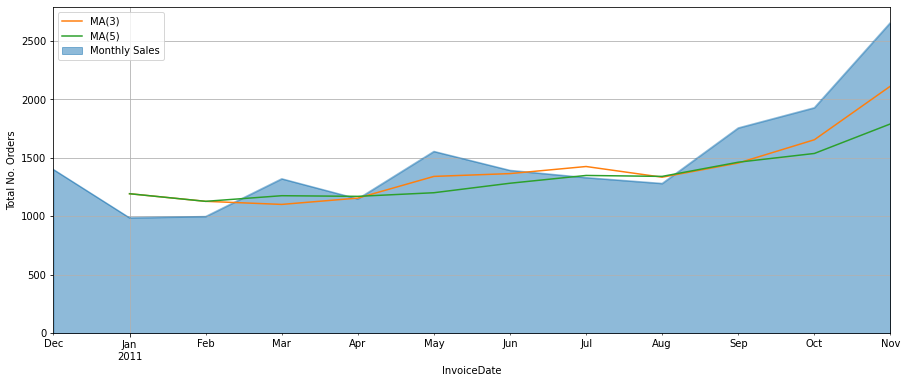

In [ ]:
# plot monthly sales again
plt.figure(figsize=(15, 6))
monthly_sales_df.plot.area(grid=True, stacked=False, label='Monthly Sales')

# to better understanding overall trends,
# I using moving average methods
monthly_sales_df.rolling(3, min_periods=2).mean().plot(grid=True, stacked=False, label='MA(3)')
monthly_sales_df.rolling(5, min_periods=2).mean().plot(grid=True, stacked=False, label='MA(5)')

plt.ylabel('Total No. Orders')
plt.legend()

The monthly number of orders floats arounds 1,250 from Dec 2010 to Aug 2011, and then increases fast from Sep 2011, and almost doubles in Nov 2011. There are some reasons that explains for significant increase from Sep 2011 to Nov 2011:
- The increase reflects the significant *growth of the business*.
- The increasing demands of purchasing at the end of years due to the impact of New Year Holidays. This is a common *seasonal pattern* in e-commerce.

The verify the above hypothesis, we need more data of previous time to make more and deeper comparisions, as well as monitorings.

### Monthly Revenue

In [ ]:
# Calculate Revenue = UnitPrice * Quantity
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# resample to monthly data
monthly_revenue_df = df.set_index('InvoiceDate')['Revenue'].resample('M').sum()
monthly_revenue_df

InvoiceDate
2010-12-31     572713.890
2011-01-31     569445.040
2011-02-28     447137.350
2011-03-31     595500.760
2011-04-30     469200.361
2011-05-31     678594.560
2011-06-30     661213.690
2011-07-31     600091.011
2011-08-31     645343.900
2011-09-30     952838.382
2011-10-31    1039318.790
2011-11-30    1161817.380
Freq: M, Name: Revenue, dtype: float64

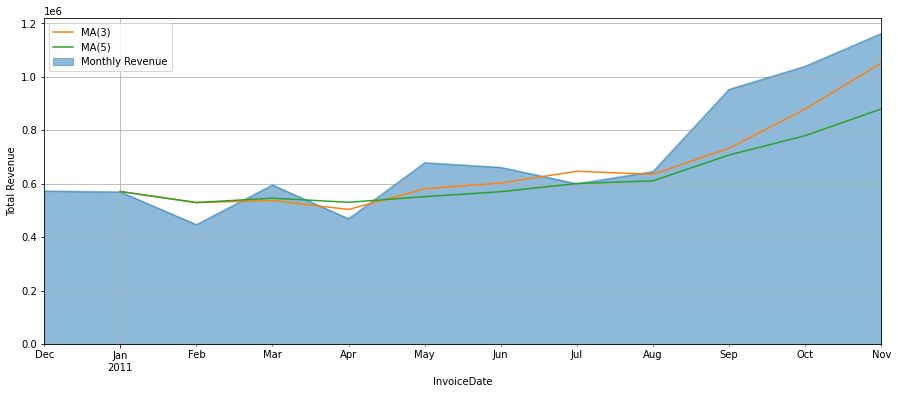

In [ ]:
# plot monthly revenue
plt.figure(figsize=(15, 6))
monthly_revenue_df.plot.area(grid=True, stacked=False, label='Monthly Revenue')

# to better understanding overall trends,
# I using moving average methods
monthly_revenue_df.rolling(3, min_periods=2).mean().plot(grid=True, stacked=False, label='MA(3)')
monthly_revenue_df.rolling(5, min_periods=2).mean().plot(grid=True, stacked=False, label='MA(5)')

plt.ylabel('Total Revenue')
plt.legend()

The pattern of total revenue seems to be similar to the one of total number of orders: floating arounds $£ \ 0.5 \times 10^6$ from Dec 2010 to Aug 2011, and then significantly increasing from Sep 2011, and over doubles in Nov 2011. We also would like some more data to deeply explain whether the increase is due to business growth or seasonal effects.

## Categorical Variables

*   List item
*   List item



In [ ]:
# Made bar charts to understand distribution of Country.
# Made pivot tables to understand relationship with Country

In [ ]:
country_dist = df_cat['Country'].value_counts().to_frame(name='# Orders')
country_dist['Proportion (%)'] = country_dist['# Orders'] / sum(country_dist['# Orders']) * 100
country_dist

,# Orders,Proportion (%)
United Kingdom,354345,89.048411
Germany,9042,2.272293
France,8342,2.096380
EIRE,7238,1.818940
Spain,2485,0.624491
Netherlands,2363,0.593832
Belgium,2031,0.510399
Switzerland,1842,0.462902
Portugal,1462,0.367407
Australia,1185,0.297796


Most of orders is national.

# Retention Analysis

In this section, we consider the number of retained customers and their effects on revenue. It is one of the most important part of a business as the cost for acquiring a new customer is more expensive than for maintaining an existing customer. A stability of a business heavily relies on retained customers. 

We wil consider the monthly retained customers. I define them is whose purchase orders within a month is more than 1.

I would like to roughly outline the steps using commented cells.

In [ ]:
# group data by each purchased orders that is defined by a pair of keys (InvoiceNo, InvoiceDate)

# monthly retained customers
## count the number of retained customers for each month
## calculate the porportion of monthly retained customers vs. total unique customers.
## visualize monthly total unique customers, retained customers, porportion of retained customers 

# monthly revenue resulting from retained customers
## count monthly revenue obtained by retained customers.
## calculate the porportion of monthly revenue obtained from retained customers vs. from total customers.
## visualize

In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Revenue'],
      dtype='object')

In [ ]:
# group data by each purchased orders that is defined by a pair of keys (InvoiceNo, InvoiceDate)
purchasedly_df= df.groupby(by=['InvoiceNo', 'InvoiceDate']).agg({
    'CustomerID': max,
    'Country': max,
    'Revenue': sum
}).reset_index()

purchasedly_df.head()

,InvoiceNo,InvoiceDate,CustomerID,Country,Revenue
0,536365,2010-12-01 08:26:00,17850.0,United Kingdom,139.12
1,536366,2010-12-01 08:28:00,17850.0,United Kingdom,22.20
2,536367,2010-12-01 08:34:00,13047.0,United Kingdom,278.73
3,536368,2010-12-01 08:34:00,13047.0,United Kingdom,70.05
4,536369,2010-12-01 08:35:00,13047.0,United Kingdom,17.85


In [ ]:
# calculate monthly retained customers
monthly_retained_customers = purchasedly_df.set_index('InvoiceDate').groupby([
    pd.Grouper(freq='M'), 'CustomerID'
]).filter(lambda x: len(x) > 1).resample('M').nunique()['CustomerID']

monthly_retained_customers

InvoiceDate
2010-12-31    263
2011-01-31    153
2011-02-28    153
2011-03-31    203
2011-04-30    170
2011-05-31    281
2011-06-30    220
2011-07-31    227
2011-08-31    198
2011-09-30    272
2011-10-31    324
2011-11-30    541
Freq: M, Name: CustomerID, dtype: int64

In [ ]:
# calculate monthly total unique customers
monthly_unique_customers = purchasedly_df.set_index('InvoiceDate')['CustomerID'].resample('M').nunique()
monthly_unique_customers

InvoiceDate
2010-12-31     885
2011-01-31     741
2011-02-28     758
2011-03-31     974
2011-04-30     856
2011-05-31    1056
2011-06-30     991
2011-07-31     949
2011-08-31     935
2011-09-30    1266
2011-10-31    1364
2011-11-30    1665
Freq: M, Name: CustomerID, dtype: int64

In [ ]:
# calculate proportion of retained customers vs. total unique customers
monthly_retention_rate = monthly_retained_customers/ monthly_unique_customers * 100
monthly_retention_rate

InvoiceDate
2010-12-31    29.717514
2011-01-31    20.647773
2011-02-28    20.184697
2011-03-31    20.841889
2011-04-30    19.859813
2011-05-31    26.609848
2011-06-30    22.199798
2011-07-31    23.919916
2011-08-31    21.176471
2011-09-30    21.484992
2011-10-31    23.753666
2011-11-30    32.492492
Freq: M, Name: CustomerID, dtype: float64

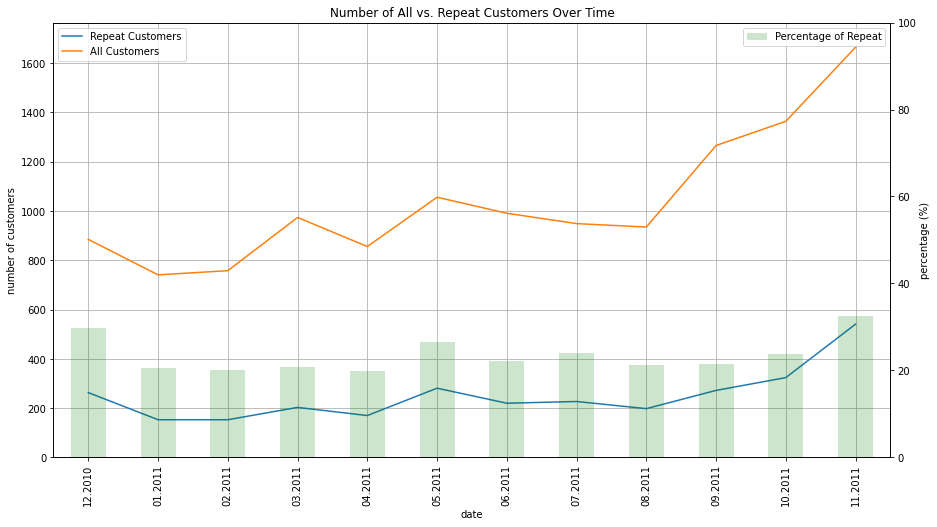

In [ ]:
# visualize monthly total unique customers, retained customers, porportion of retained customers
ax = pd.DataFrame(monthly_retained_customers.values).plot(figsize=(15, 8))

pd.DataFrame(monthly_unique_customers.values).plot(ax=ax, grid=True)

ax2 = pd.DataFrame(monthly_retention_rate.values).plot.bar(
  ax=ax,
  grid=True,
  secondary_y=True,
  color='green',
  alpha=0.2
)

ax.set_xlabel('date')
ax.set_ylabel('number of customers')
ax.set_title('Number of All vs. Repeat Customers Over Time')

ax2.set_ylabel('percentage (%)')

ax.legend(['Repeat Customers', 'All Customers'])
ax2.legend(['Percentage of Repeat'], loc='upper right')

ax.set_ylim([0, monthly_unique_customers.values.max()+100])
ax2.set_ylim([0, 100])

plt.xticks(
    range(len(monthly_retained_customers.index)), 
    [x.strftime('%m.%Y') for x in monthly_retained_customers.index], 
    rotation=45
)

plt.show()

The total customers, and retained customers significantly increase from Sep 2011. The monthly retention rate remains quite stably between 20% - 30%. The business keeps stable by benefiting from this steady stream of retained customers.

In [ ]:
# count monthly revenue obtained by retained customers.

monthly_retained_revenue = purchasedly_df.set_index('InvoiceDate').groupby([
    pd.Grouper(freq='M'), 'CustomerID'
]).filter(lambda x: len(x) > 1).resample('M').sum()['Revenue']

monthly_retained_revenue

InvoiceDate
2010-12-31    359170.60
2011-01-31    222124.00
2011-02-28    191229.37
2011-03-31    267390.48
2011-04-30    195474.18
2011-05-31    378197.04
2011-06-30    376307.26
2011-07-31    317475.00
2011-08-31    317134.25
2011-09-30    500663.36
2011-10-31    574006.87
2011-11-30    713775.85
Freq: M, Name: Revenue, dtype: float64

In [ ]:
# calculate the porportion of monthly revenue obtained from retained customers vs. from total customers.
monthly_retained_revenue_proportion = monthly_retained_revenue/ monthly_revenue_df * 100
monthly_retained_revenue_proportion

InvoiceDate
2010-12-31    62.713792
2011-01-31    39.007101
2011-02-28    42.767478
2011-03-31    44.901787
2011-04-30    41.661132
2011-05-31    55.732401
2011-06-30    56.911595
2011-07-31    52.904475
2011-08-31    49.141899
2011-09-30    52.544416
2011-10-31    55.229144
2011-11-30    61.436148
Freq: M, Name: Revenue, dtype: float64

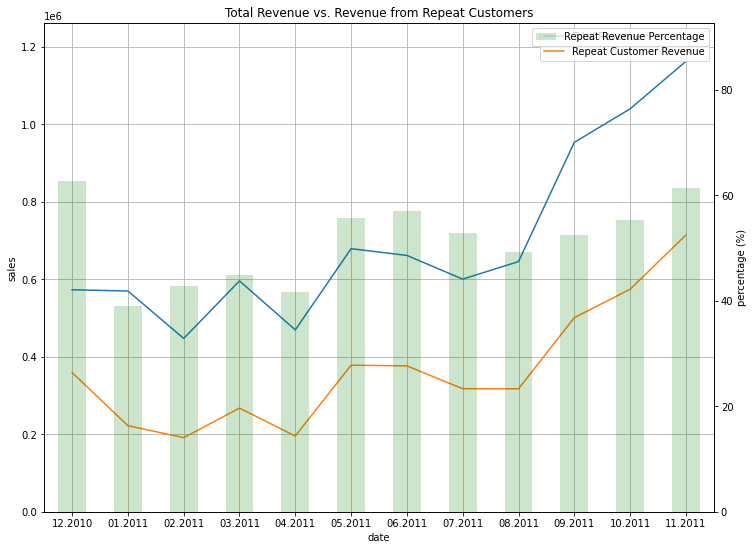

In [ ]:
# visualize
ax = pd.DataFrame(monthly_revenue_df.values).plot(figsize=(12,9))

pd.DataFrame(monthly_retained_revenue.values).plot(
    ax=ax,
    grid=True,
)

ax.set_xlabel('date')
ax.set_ylabel('sales')
ax.set_title('Total Revenue vs. Revenue from Repeat Customers')

ax.legend(['Total Revenue', 'Repeat Customer Revenue'])

ax.set_ylim([0, max(monthly_revenue_df.values)+100000])

ax2 = ax.twinx()

pd.DataFrame(monthly_retained_revenue_proportion.values).plot(
    ax=ax2,
    kind='bar',
    color='g',
    alpha=0.2
)

ax2.set_ylim([0, max(monthly_retained_revenue_proportion.values)+30])
ax2.set_ylabel('percentage (%)')
ax2.legend(['Repeat Revenue Percentage'])

ax2.set_xticklabels([
    x.strftime('%m.%Y') for x in monthly_retained_revenue_proportion.index
])

plt.show()

Monthly Revenue and Monthly from-retained-customers Revenue significantly increase from Aug 2011.

In [ ]:
# average monthly from-retained-customers Revenue proportion
sum(monthly_retained_revenue_proportion.values) / len(monthly_retained_revenue_proportion)

51.245947371206775

By average, over 50% of business revenue is from retained customers.

# Clustering

We want to cluster customers into groups so that customers in a group are similar together, and differentiate with not-within-group customers. The data we got is customer and orders. I want to see clusters of customers with respect to their value bringing to the business.

## Data Preprocessing
As my purpose, I represent a customers with 3 pieces of information: 
- TotalRevenue: total money a customer contribute to the business.
- OrderCount: number of orders they performed.
- AvgOrderValue: value of an order on average.

In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Revenue'],
      dtype='object')

In [ ]:
# assign each unique customer with 3 mentioned information
customerly_df = df.groupby('CustomerID').agg({
    'Revenue': sum,
    'InvoiceNo': lambda x: x.nunique(),
})

customerly_df.columns = ['TotalRevenue', 'OrderCount']
customerly_df['AvgOrderValue'] = customerly_df['TotalRevenue']/customerly_df['OrderCount']

customerly_df

,TotalRevenue,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,77183.60,1,77183.600000
12347.0,4085.18,6,680.863333
12348.0,1797.24,4,449.310000
12349.0,1757.55,1,1757.550000
12350.0,334.40,1,334.400000
...,...,...,...
18280.0,180.60,1,180.600000
18281.0,80.82,1,80.820000
18282.0,100.21,1,100.210000


## Using Kmeans

1. Normalize data
2. Pick k
3. Fit K-Means Models

In [ ]:
# normalize data

## force values in each column in range (0, 4298)
ranked_customerly_df = customerly_df.rank(method='first')

## normalize data to Gaussian
normalized_customerly_df = (ranked_customerly_df - ranked_customerly_df.mean()) / ranked_customerly_df.std()

normalized_customerly_df

,TotalRevenue,OrderCount,AvgOrderValue
CustomerID,,,
12346.0,1.724999,-1.731446,1.731446
12347.0,1.457445,1.064173,1.401033
12348.0,0.967466,0.573388,0.929590
12349.0,0.944096,-1.730641,1.683093
12350.0,-0.732148,-1.729835,0.331622
...,...,...,...
18280.0,-1.272091,-0.493605,-0.850613
18281.0,-1.648440,-0.492799,-1.596058
18282.0,-1.604922,-0.491993,-1.517887


In [ ]:
# better understand distribution of our data
normalized_customerly_df.describe()

,TotalRevenue,OrderCount,AvgOrderValue
count,4.298000e+03,4.298000e+03,4.298000e+03
mean,9.952744e-17,-1.231371e-16,5.719018e-17
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.731446e+00,-1.731446e+00,-1.731446e+00
25%,-8.657232e-01,-8.657232e-01,-8.657232e-01
50%,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.657232e-01,8.657232e-01,8.657232e-01
max,1.731446e+00,1.731446e+00,1.731446e+00


In [ ]:
# Pick an optimal the number of clusters
## using Elbow methods (using distortion (i.e. SSE), and Silhouette score)

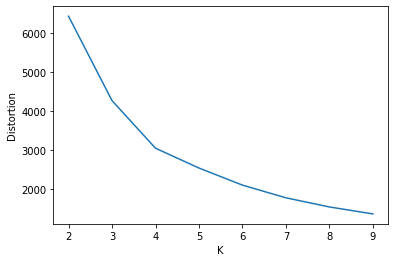

In [ ]:
from sklearn import cluster
from sklearn.cluster import KMeans

k_range = range(2, 10)

distortions = []
X = normalized_customerly_df[['TotalRevenue','OrderCount','AvgOrderValue']].values

for n in k_range:
    model = cluster.KMeans(n_clusters=n, random_state=4)
    model.fit_predict(X)
    cluster_assignments = model.labels_
    centers = model.cluster_centers_
    distortions.append(np.sum((X - centers[cluster_assignments]) ** 2))

plt.plot(k_range, distortions)
plt.xlabel("K")
plt.ylabel("Distortion")
plt.show()

It looks like k=4 is my 'elbow'. 

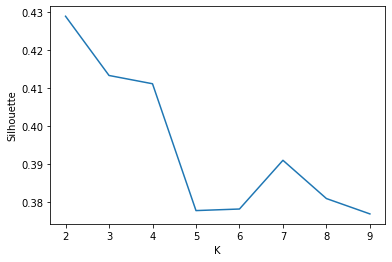

In [ ]:
from sklearn.metrics import silhouette_score

silhouettes = []

for n in k_range:
    model = cluster.KMeans(n_clusters=n, random_state=4)
    model.fit(X)
    silhouettes.append(silhouette_score(X, model.labels_))

plt.plot(k_range, silhouettes)
plt.xlabel("K")
plt.ylabel("Silhouette")
plt.show()

It looks like 4 is optimal, too.

In [ ]:
# fitting kmeans model
kmeans = KMeans(n_clusters=4).fit(X)

In [ ]:
# intergate each customers and its cluster into a dataframe
fourmeans_cluster_df = normalized_customerly_df.copy()
fourmeans_cluster_df['Cluster'] = kmeans.labels_
fourmeans_cluster_df

,TotalRevenue,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,1.724999,-1.731446,1.731446,0
12347.0,1.457445,1.064173,1.401033,2
12348.0,0.967466,0.573388,0.929590,2
12349.0,0.944096,-1.730641,1.683093,0
12350.0,-0.732148,-1.729835,0.331622,0
...,...,...,...,...
18280.0,-1.272091,-0.493605,-0.850613,3
18281.0,-1.648440,-0.492799,-1.596058,3
18282.0,-1.604922,-0.491993,-1.517887,3


In [ ]:
# assign clusters to before-normalized data
customerly_df['Cluster'] = kmeans.labels_
customerly_df

,TotalRevenue,OrderCount,AvgOrderValue,Cluster
CustomerID,,,,
12346.0,77183.60,1,77183.600000,0
12347.0,4085.18,6,680.863333,2
12348.0,1797.24,4,449.310000,2
12349.0,1757.55,1,1757.550000,0
12350.0,334.40,1,334.400000,0
...,...,...,...,...
18280.0,180.60,1,180.600000,3
18281.0,80.82,1,80.820000,3
18282.0,100.21,1,100.210000,3


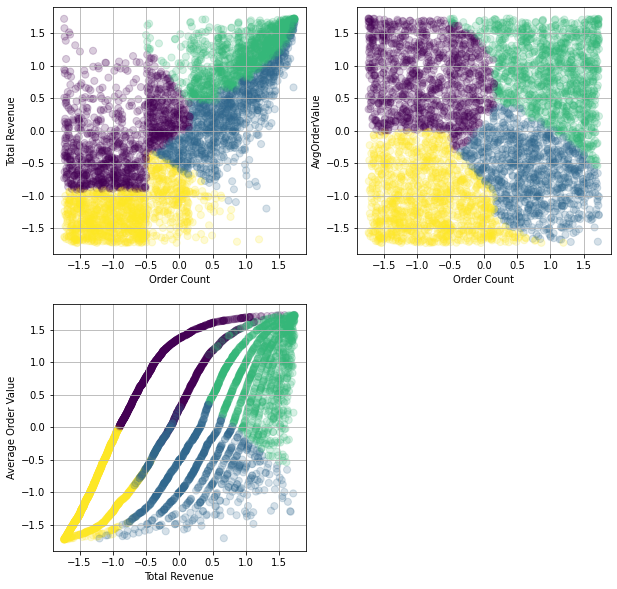

In [ ]:
# visualize clusters in 2D: TotalRevenue and OrderCount
plt.figure(figsize=(10, 10))

plt.subplot(221)
plt.scatter(
    fourmeans_cluster_df['OrderCount'], 
    fourmeans_cluster_df['TotalRevenue'], 
    c=fourmeans_cluster_df['Cluster'], 
    s=50, 
    cmap='viridis',
    alpha=0.2)
plt.xlabel('Order Count')
plt.ylabel('Total Revenue')
plt.grid()

plt.subplot(222)
plt.scatter(
    fourmeans_cluster_df['OrderCount'], 
    fourmeans_cluster_df['AvgOrderValue'], 
    c=fourmeans_cluster_df['Cluster'], 
    s=50, 
    cmap='viridis',
    alpha=0.2)
plt.xlabel('Order Count')
plt.ylabel('AvgOrderValue')
plt.grid()

plt.subplot(223)
plt.scatter(
    fourmeans_cluster_df['TotalRevenue'], 
    fourmeans_cluster_df['AvgOrderValue'], 
    c=fourmeans_cluster_df['Cluster'], 
    s=50, 
    cmap='viridis',
    alpha=0.2)
plt.xlabel('Total Revenue')
plt.ylabel('Average Order Value')
plt.grid()

plt.show()

*We* have a cluster is customers whose total revenue, order count, and average order value is lowest. We can define this kind of cluster as lowest-value customers.

We have a cluster is customers whose total revenue, order count, and average order value is highest. We can define this kind of cluster as highest-value customers.

In [ ]:
kmeans.cluster_centers_

array([[-0.13271459, -0.85015948,  0.79867905],
       [ 0.21602564,  0.71335285, -0.64277193],
       [ 1.20623695,  1.00587146,  0.86737214],
       [-1.24710742, -0.79832009, -1.06143209]])

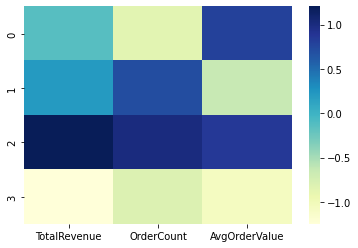

In [ ]:
fourmeans_cluster_centroid_df = pd.DataFrame(kmeans.cluster_centers_, columns=['TotalRevenue', 'OrderCount', 'AvgOrderValue'])
sns.heatmap(fourmeans_cluster_centroid_df, cmap="YlGnBu")

In [ ]:
customerly_df.columns

Index(['TotalRevenue', 'OrderCount', 'AvgOrderValue', 'Cluster'], dtype='object')

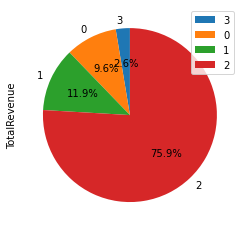

In [ ]:
# contribution on business revenue of clusters
customerly_df.groupby('Cluster').agg({
    'TotalRevenue': sum
}).sort_values('TotalRevenue').plot.pie(y='TotalRevenue', autopct='%1.1f%%', startangle=90)


Based on the centroid, 
- There is a cluster of high-value customers whose amount of revenue, number of orders, average per-order value is all highest. The business should focus on the marketing efforts on this segment of customers as it will result in the highest returns.
- There is a cluster of low-value customers whose three attribute is all lowest. 
- There is an interesting cluster of customers whose amount of revenue is medium (about 9.6% of total revenue), number of orders is low, but average per-order value is high. This means those customers buy expensive items, and also bring the business medium returns.
- The last segment of customers is also interesting where their amount of revenue is medium (about 11.8% of total revenue), average per-order value is low, but number of orders is high. Those customers buy not expensive items but very frequently. So, the business should put their marketing efforts for this segment on items with low per-item prices as their contribution on business return is quite high.

In [ ]:
fourmeans_cluster_df.columns

Index(['TotalRevenue', 'OrderCount', 'AvgOrderValue', 'Cluster'], dtype='object')

In [ ]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Revenue'],
      dtype='object')

In [ ]:
# find top 5 best-selling items for each clusters

bestselling_items_df = pd.DataFrame()
for k in range(0, 4):
  cluster_k = fourmeans_cluster_df.loc[fourmeans_cluster_df['Cluster'] == k]
  bestselling_items = df.loc[df['CustomerID'].isin(cluster_k.index)].groupby(
      'StockCode'
  ).count()['Description'].sort_values(ascending=False).head().to_frame().reset_index()
  
  bestselling_items.columns = ['StockCode', 'Count']

  bestselling_items['Cluster'] = k

  bestselling_items = pd.merge(
      bestselling_items, 
      df[['StockCode', 'Description', 'UnitPrice']], 
      how='left', 
      on='StockCode',
  ).groupby('StockCode').agg({
      'Description': max,
      'Count': max,
      'UnitPrice': max,
      'Cluster': max,
  }).sort_values('Count', ascending=False)
  
  bestselling_items_df = pd.concat(
      [bestselling_items_df, bestselling_items]
  )

bestselling_items_df

,Description,Count,UnitPrice,Cluster
StockCode,,,,
22423,REGENCY CAKESTAND 3 TIER,201,24.96,0
85123A,WHITE HANGING HEART T-LIGHT HOLDER,157,5.79,0
84879,ASSORTED COLOUR BIRD ORNAMENT,155,1.69,0
22720,SET OF 3 CAKE TINS PANTRY DESIGN,151,10.79,0
47566,PARTY BUNTING,137,10.79,0
85123A,WHITE HANGING HEART T-LIGHT HOLDER,613,5.79,1
21034,REX CASH+CARRY JUMBO SHOPPER,436,0.95,1
22423,REGENCY CAKESTAND 3 TIER,318,24.96,1
47566,PARTY BUNTING,309,10.79,1
